In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import product

In [2]:
def fit_and_plot(data, xcol, ycol):
    """
    I'll be doing this many times in the analysis so I made it a function
    required input:
    - a pandas dataframe containing the x and y data
    - the string for the dataframe column with independent values
    - the string for the dataframe column with dependent values
    returns:
    - the slope
    - the intercept
    - the R^2 value
    - pvalue of lack of fit test
    - the figure object that the fit and residuals are drawn on
    """
    # useful quantities
    xbar = data[xcol].mean()
    ybar = data[ycol].mean()
    Sxx = np.sum((data[xcol] - xbar)**2)
    Sxy = np.sum((data[xcol] - xbar) * (data[ycol] - ybar))
    Syy = np.sum((data[ycol] - ybar)**2)

    # estimate fit parameters and add fit + residuals to dataframe
    B1 = Sxy / Sxx
    B0 = ybar - B1*xbar
    fitcol = xcol + ycol + "_fit"
    rescol = xcol + ycol + "_res"
    data[fitcol] = np.polyval([B1, B0], data[xcol])
    data[rescol] = data[ycol] - data[fitcol]
    SSres = np.sum(data[rescol]**2)

    # compute r, r squared, degrees of freedom, and mean squared error
    r = Sxy/np.sqrt(Sxx*Syy)
    rsq = r**2
    n = len(data)
    dof = n - 2
    MSE = np.sqrt(np.sum((data[ycol] - data[fitcol])**2) / dof)

    # compute .95 confidence and prediction intervals and add to dataframe
    t = stats.t.ppf(0.975, dof)
    CI = t * MSE * np.sqrt(1/n + ((data[xcol]-xbar)**2)/Sxx)
    PI = t * MSE * np.sqrt(1 + 1/n + ((data[xcol]-xbar)**2)/Sxx)

    upper_ci_col = xcol + ycol + "_upperCI"
    lower_ci_col = xcol + ycol + "_lowerCI"
    upper_pi_col = xcol + ycol + "_upperPI"
    lower_pi_col = xcol + ycol + "_lowerPI"

    data[upper_ci_col] = data[fitcol] + CI
    data[lower_ci_col] = data[fitcol] - CI
    data[upper_pi_col] = data[fitcol] + PI
    data[lower_pi_col] = data[fitcol] - PI

    # break data into levels to prepare for lack of fit test
    break_idx = np.nonzero(np.diff(data[xcol]))[0] + 1
    levels_x = np.split(np.asarray(data[xcol]), break_idx)
    levels_y = np.split(np.asarray(data[ycol]), break_idx)

    # find pure experimental error and error due to lack of fit
    SSPexp = 0
    SSPexp_dof = 0
    for ly in levels_y:
        lybar = ly.mean()
        SSPexp += np.sum((ly - lybar)**2)
        SSPexp_dof += len(ly) - 1
    SSlack = SSres - SSPexp
    SSlack_dof = n - 2 - SSPexp_dof

    # calculate the statistic and result of the lack of fit test
    F0 = (SSPexp*SSlack_dof) / (SSlack*SSPexp_dof)
    pLOF = stats.f.cdf(F0, SSPexp_dof, SSlack_dof)

    # visualize
    fig, (fax, rax) = plt.subplots(2, layout="tight",
                                   sharex=True)

    # plot the fit
    fax.set_ylabel("$"+ycol+"$")
    fax.scatter(data[xcol], data[ycol],
                marker=".", color="black")
    l = "$\\beta_1 = %.2f$\n$\\beta_0 = %.2f$\n$r^2 = %.2f$\n$r_{s} = %.2f$"\
         %(B1, B0, rsq, r)
    fax.plot(data[xcol], data[fitcol],
             color="red", label=l)
    
    # plot .95 CI and PI
    fax.fill_between(data[xcol], data[upper_ci_col], data[lower_ci_col],
                     color="pink", alpha=0.5,
                     edgecolor="red", linestyle="dashed",
                     label="$95\%$ CI")
    fax.fill_between(data[xcol], data[upper_pi_col], data[lower_pi_col],
                     color="lightpink", alpha=0.5,
                     edgecolor="red", linestyle="dotted",
                     label="$95\%$ PI")

    fax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

    # residuals with mean and 1 sigma error band
    rax.set_ylabel("$"+ycol+"-\hat{y}$")
    rax.set_xlabel("$"+xcol+"$")
    rax.scatter(data[xcol], data[rescol],
                marker=".", color="black")
    res_mean = data[rescol].mean()
    res_std_dev = np.std(data[rescol])
    l = "$\\overline{res} = %.2f$\n$SS_{res} = %.2f$\n$SSP_{exp} = %.2f$\n$SS_{lack} = %.2f$\n$p_{LOF} = %.4f$"\
        %(res_mean, SSres, SSPexp, SSlack, pLOF)
    rax.hlines(res_mean, min(data[xcol]), max(data[xcol]),
               color="red", label=l)
    l = "$\\sigma_{res} = %.2f$" %res_std_dev
    rax.fill_between(data[xcol], res_mean+res_std_dev, res_mean-res_std_dev,
                     color="pink", alpha=0.5,
                     edgecolor="red", linestyle="dashed",
                     label=l)
    rax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

    return B1, B0, rsq, pLOF, fig

/tmp/ipykernel_81324/1043014349.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  F0 = (SSPexp*SSlack_dof) / (SSlack*SSPexp_dof)


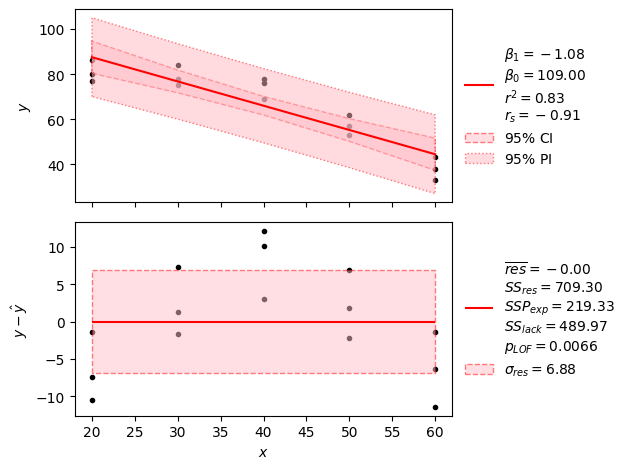

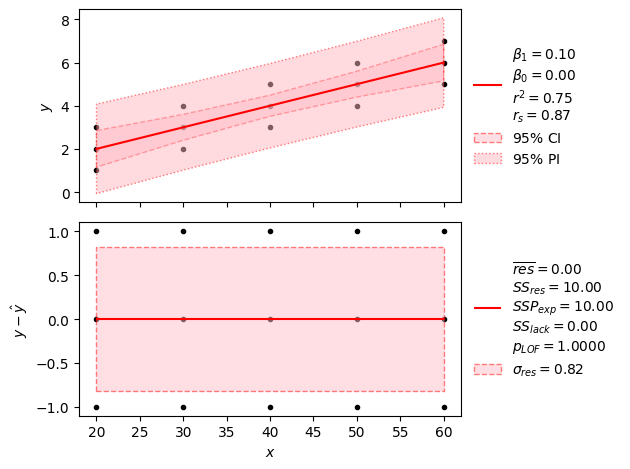

In [3]:
ldata = pd.DataFrame({"x": [20,20,20, 30,30,30, 40,40,40, 50,50,50, 60,60,60],
                      "y": [86,80,77, 78,84,75, 78,69,76, 62,53,57, 33,38,43]})
wdata = pd.DataFrame({"x": [20,20,20, 30,30,30, 40,40,40, 50,50,50, 60,60,60],
                      "y": [1,2,3, 2,3,4, 3,4,5, 4,5,6, 5,6,7]})
l = fit_and_plot(ldata, "x", "y")
w = fit_and_plot(wdata, "x", "y")
l[4].savefig("figures/lof_test_fail.png")
w[4].savefig("figures/lof_test_pass.png")